Import Libraries, data and Initialisation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans,DBSCAN

In [2]:
#file_path = r"C:\MSc DTU\Semester 1\00. Introduction to BA\Assignment\city-bike\Trips_2018_clean.csv"
data = pd.read_csv('dataV/Trips_2018_clean.csv')
data.head()


,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_time,stop_time
0,970,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1,1992,1,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186
1,723,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1,1969,1,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341
2,496,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1,1956,1,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172
3,306,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1,1974,1,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191
4,306,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1,1992,1,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642


In [ ]:
# Get unique station IDs and their coordinates from both start and end stations
stations_start = data[['start_station_id', 'start_station_latitude', 'start_station_longitude']].drop_duplicates()
stations_end = data[['end_station_id', 'end_station_latitude', 'end_station_longitude']].drop_duplicates()

# Rename columns for consistency
stations_start.columns = ['station_id', 'latitude', 'longitude']
stations_end.columns = ['station_id', 'latitude', 'longitude']

# Combine and keep unique station IDs
stations_combined = pd.concat([stations_start, stations_end], ignore_index=True)
stations_coordinates = stations_combined.drop_duplicates(subset='station_id')

print(f"Total unique stations with coordinates: {len(stations_coordinates)}")
#print(stations_coordinates.head(10))

#Check outliers
stations_coordinates = stations_coordinates[(stations_coordinates['latitude'].between(40.45, 40.92)) & (stations_coordinates['longitude'].between(-74.30, -73.65))]
print(f"Total unique stations with coordinates after removing outliers: {len(stations_coordinates)}")

Total unique stations with coordinates: 849
Total unique stations with coordinates after removing outliers: 848


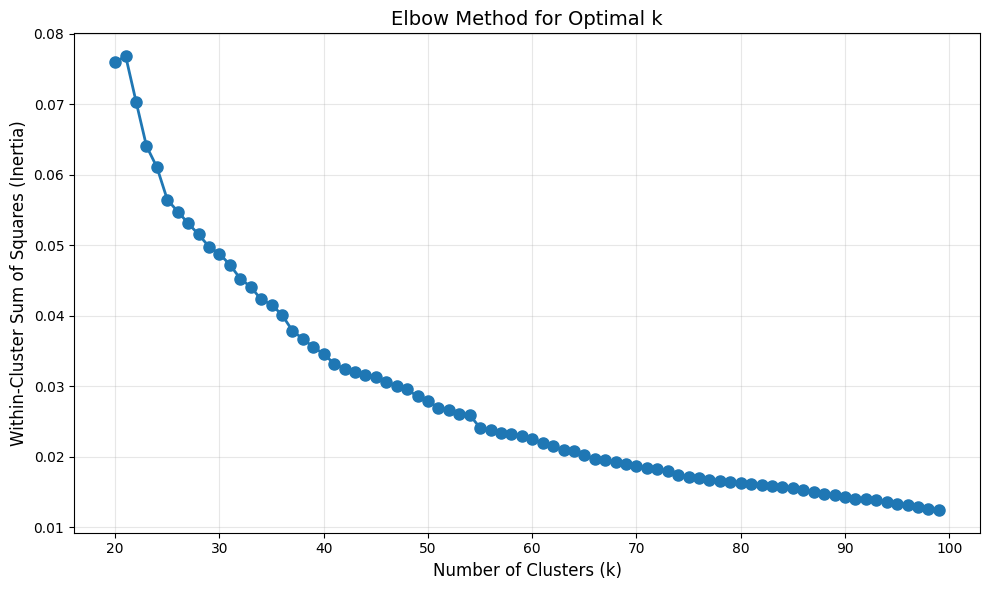

In [46]:
# Different k values
k_values = np.arange(20,100,1)

# ELBOW METHOD: Calculate inertia (within-cluster sum of squares) for each k
inertias = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(stations_coordinates[['latitude', 'longitude']])
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (Inertia)', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


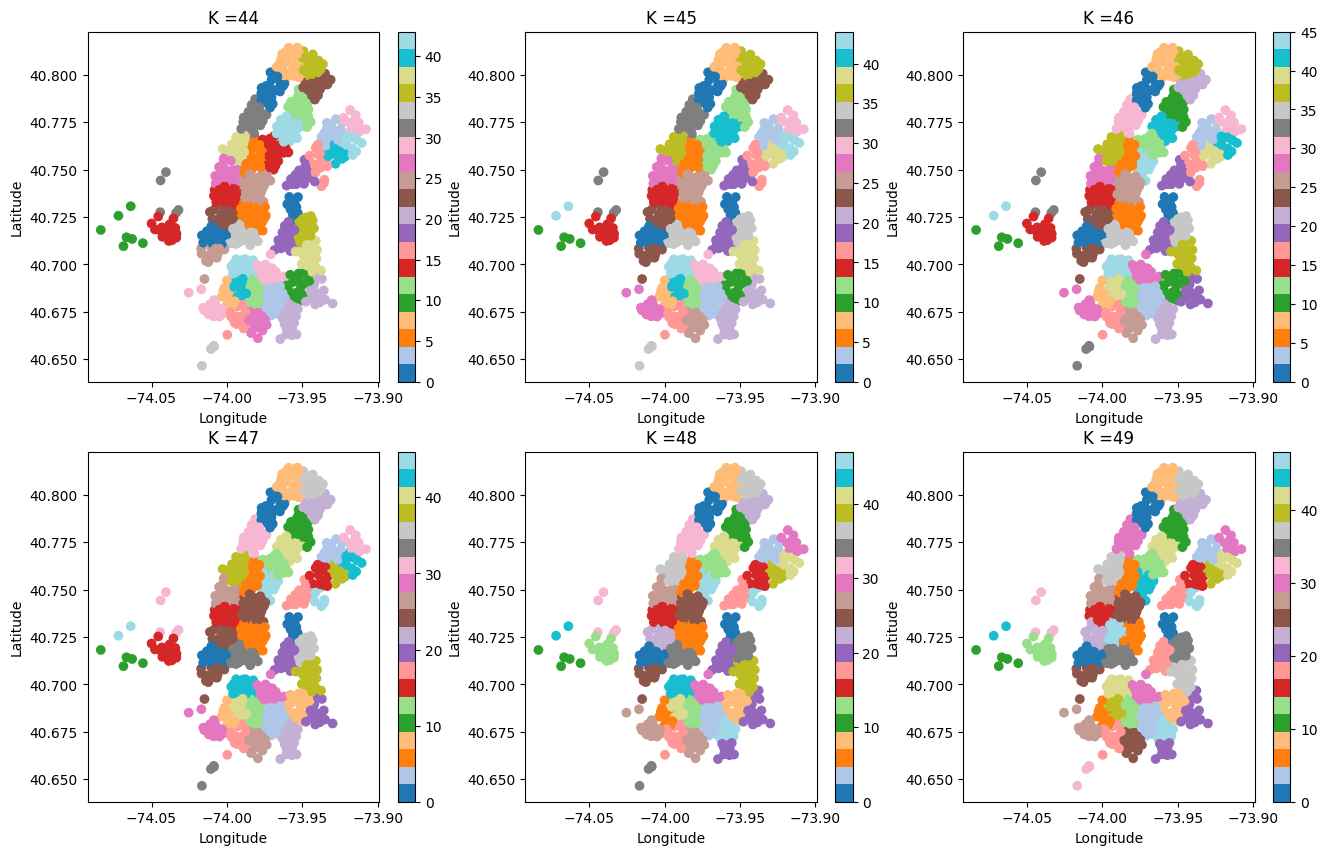

In [49]:
k_values = [44,45,46,47,48,49]

#Plot the clustering results for different k values for k-means clustering
fig,axes = plt.subplots(2,3,figsize=(16,10))
axes = axes.ravel()

for i,k in enumerate(k_values):
    #Fit k-means
    kmeans = KMeans(n_clusters=k,random_state=1)
    clusters = kmeans.fit_predict(stations_coordinates[['latitude', 'longitude']])

    # Add cluster assignment as a new column for each k
    stations_coordinates[f'cluster_{k}'] = clusters

    scatter = axes[i].scatter(stations_coordinates['longitude'],stations_coordinates['latitude'],c=clusters,cmap='tab20')
    axes[i].set_title(f'K ={k}')
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')
    plt.colorbar(scatter,ax=axes[i])

plt.show()

In [5]:
db_station_coordinates = stations_coordinates

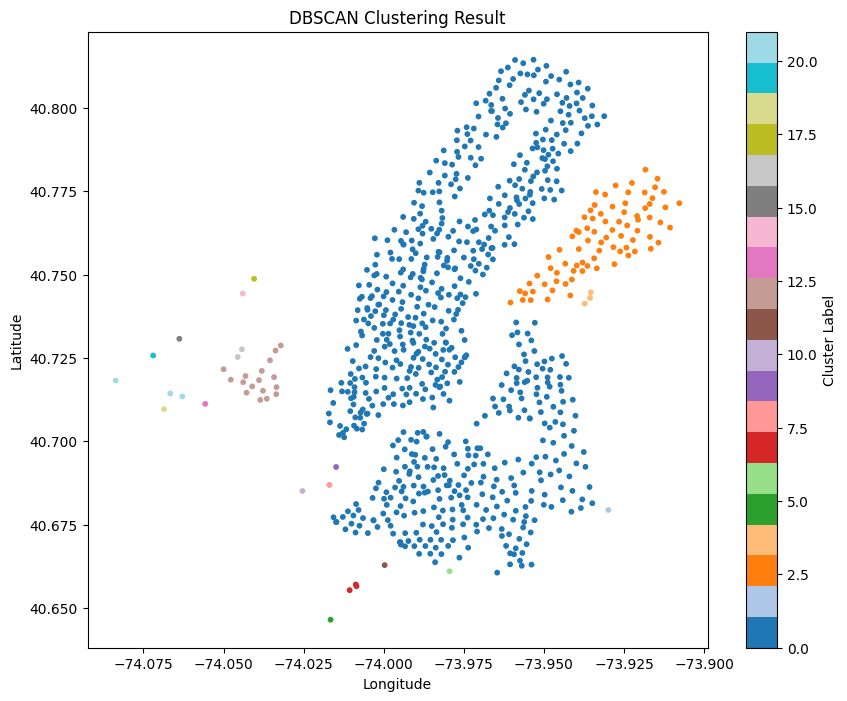

Number of clusters: 21
Number of noise points: 0


In [45]:
# DBSCAN parameters: you can adjust eps and min_samples
eps = 0.005  # Maximum distance between two samples for them to be considered in the same cluster
min_samples = 1  # Minimum number of samples in a neighborhood for a point to be considered a core point

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(db_station_coordinates[['latitude','longitude']])

# Add cluster assignment as a new column
db_station_coordinates['cluster_dbscan'] = clusters

# Visualize the result
plt.figure(figsize=(10, 8))
plt.scatter(db_station_coordinates['longitude'], db_station_coordinates['latitude'],
            c=db_station_coordinates['cluster_dbscan'], cmap='tab20', s=10)
plt.title('DBSCAN Clustering Result')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster Label')
plt.show()

print(f"Number of clusters: {len(set(db_station_coordinates['cluster_dbscan']))-1}")  # -1 because -1 means noise
print(f"Number of noise points: {list(db_station_coordinates['cluster_dbscan']).count(-1)}")

In [13]:
# Create a dictionary for fast lookup: station_id -> cluster_20
cluster_map = stations_coordinates.set_index('station_id')['cluster_20']

# Add new columns to dataframe with start and end stations' cluster index
data['start_cluster_20'] = data['start_station_id'].map(cluster_map)
data['end_cluster_20'] = data['end_station_id'].map(cluster_map).astype("Int32")

print(data[['start_cluster_20','end_cluster_20']])

          start_cluster_20  end_cluster_20
0                        8               5
1                        8              18
2                        8               8
3                        8               8
4                        8               8
...                    ...             ...
17545756                18               5
17545757                 2               8
17545758                 1               1
17545759                 2              19
17545760                18              18

[17545761 rows x 2 columns]


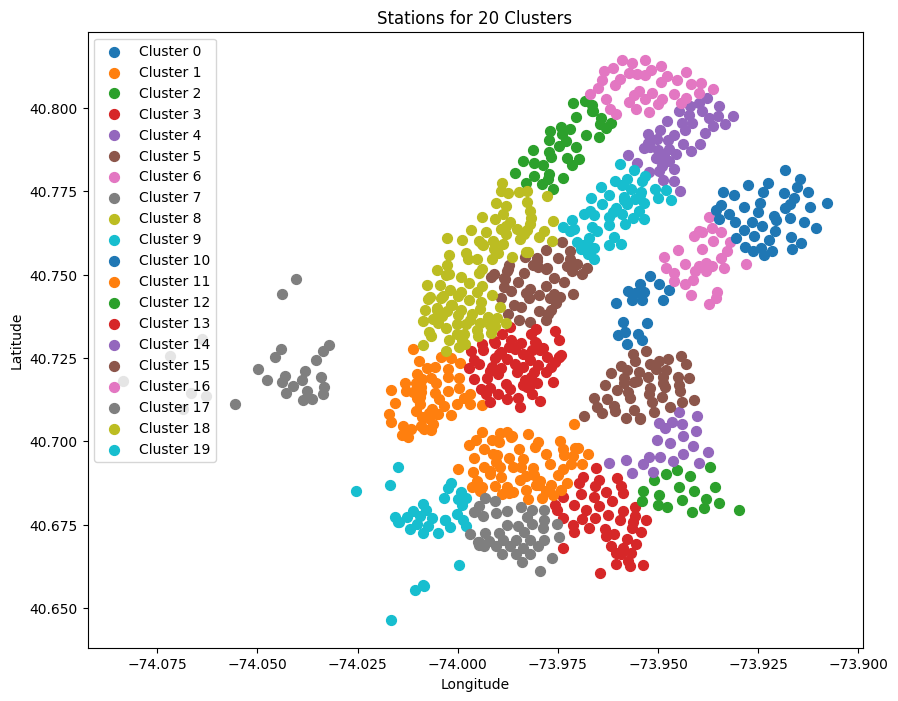

In [14]:
# Clusters to visualize
target_clusters = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

# Filter for target clusters
data_plot = stations_coordinates[stations_coordinates['cluster_20'].isin(target_clusters)]

# Plot the stations
plt.figure(figsize=(10, 8))
for cluster in target_clusters:
    cluster_data = data_plot[data_plot['cluster_20'] == cluster]
    plt.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {cluster}', s=50)

plt.title('Stations for 20 Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [15]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Create a map centered on the data
map_center = [data_plot['latitude'].mean(), data_plot['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Generate a color for each cluster using a colormap
colormap = cm.get_cmap('tab20', len(target_clusters))
colors = [mcolors.to_hex(colormap(i)) for i in range(len(target_clusters))]

# Add markers for each cluster
for idx, cluster in enumerate(target_clusters):
    cluster_data = data_plot[data_plot['cluster_20'] == cluster]
    color = colors[idx]
    
    for _, row in cluster_data.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            color=color,
            radius=6,
            fill=True,
            fill_color=color,
            popup=f"Cluster: {cluster}"
        ).add_to(m)

m.save('clusters_map.html')

C:\Users\billy\AppData\Local\Temp\ipykernel_16364\1754185308.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', len(target_clusters))


We will now work pickups and dropoffs for Clusters 5,15,18

In [16]:
# Convert start_time and stop_time columns to datetime
data['start_time'] = pd.to_datetime(data['start_time'], format="%Y-%m-%d %H:%M:%S.%f")
data['stop_time'] = pd.to_datetime(data['stop_time'], format="%Y-%m-%d %H:%M:%S.%f")

data.head()


,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_time,stop_time,start_cluster_20,end_cluster_20
0,970,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1,1992,1,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,8,5
1,723,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1,1969,1,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,8,18
2,496,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1,1956,1,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,8,8
3,306,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1,1974,1,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,8,8
4,306,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1,1992,1,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,8,8


In [17]:
# Filter trips for the target clusters (5, 15, 18)
target_clusters = [5]
#target_cluster = [15]
#target_cluster = [18]
data_filtered = data[data['start_cluster_20'].isin(target_clusters)].copy()

data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2261371 entries, 18769 to 17545753
Data columns (total 15 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   tripduration             int64         
 1   start_station_id         float64       
 2   start_station_latitude   float64       
 3   start_station_longitude  float64       
 4   end_station_id           float64       
 5   end_station_latitude     float64       
 6   end_station_longitude    float64       
 7   bikeid                   int64         
 8   usertype                 int64         
 9   birth_year               int64         
 10  gender                   int64         
 11  start_time               datetime64[ns]
 12  stop_time                datetime64[ns]
 13  start_cluster_20         int32         
 14  end_cluster_20           Int32         
dtypes: Int32(1), datetime64[ns](2), float64(6), int32(1), int64(5)
memory usage: 260.9 MB


In [18]:
# Create pickup hour and date columns
data_filtered['pickup_hour'] = data_filtered['start_time'].dt.hour
data_filtered['date'] = data_filtered['start_time'].dt.date

data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2261371 entries, 18769 to 17545753
Data columns (total 17 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   tripduration             int64         
 1   start_station_id         float64       
 2   start_station_latitude   float64       
 3   start_station_longitude  float64       
 4   end_station_id           float64       
 5   end_station_latitude     float64       
 6   end_station_longitude    float64       
 7   bikeid                   int64         
 8   usertype                 int64         
 9   birth_year               int64         
 10  gender                   int64         
 11  start_time               datetime64[ns]
 12  stop_time                datetime64[ns]
 13  start_cluster_20         int32         
 14  end_cluster_20           Int32         
 15  pickup_hour              int32         
 16  date                     object        
dtypes: Int32(1), datetime64[ns]

In [19]:
# Count pickups per hour, per day (for this cluster)
cluster_hourly = (
    data_filtered
    .groupby(['date', 'pickup_hour'])
    ['start_station_id']
    .size()
    .reset_index()
    .rename(columns={'start_station_id': 'pickups'})
)
cluster_hourly.head()

,date,pickup_hour,pickups
0,2018-01-01,0,12
1,2018-01-01,1,15
2,2018-01-01,2,7
3,2018-01-01,3,7
4,2018-01-01,4,2


In [20]:
cluster_hourly['datetime'] = pd.to_datetime(
    cluster_hourly['date'].astype(str) + ' ' +
    cluster_hourly['pickup_hour'].astype(str) + ':00:00'
)
cluster_hourly = cluster_hourly.sort_values('datetime')

In [21]:
# Ensure datetime index and hourly frequency
chd = (
    cluster_hourly
    .set_index('datetime')
    .sort_index()
    .asfreq('H')              # guarantees continuous hourly timeline
    .fillna({'pickups': 0})  # fill missing hours if any
)

# Keep only 2018 samples
chd_2018 = chd.loc['2018-01-01':'2018-12-31 23:00']

# Train: Jan–Oct 2018
train_data = chd_2018.loc['2018-01-01':'2018-10-31 23:00', 'pickups']

# Test: Nov–Dec 2018
test_data  = chd_2018.loc['2018-11-01 00:00':'2018-12-31 23:00', 'pickups']

C:\Users\billy\AppData\Local\Temp\ipykernel_16364\1938098801.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .asfreq('H')              # guarantees continuous hourly timeline


C:\Users\billy\AppData\Local\Temp\ipykernel_16364\430030329.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=last_train_datetime + pd.Timedelta(hours=1), periods=24, freq='H')


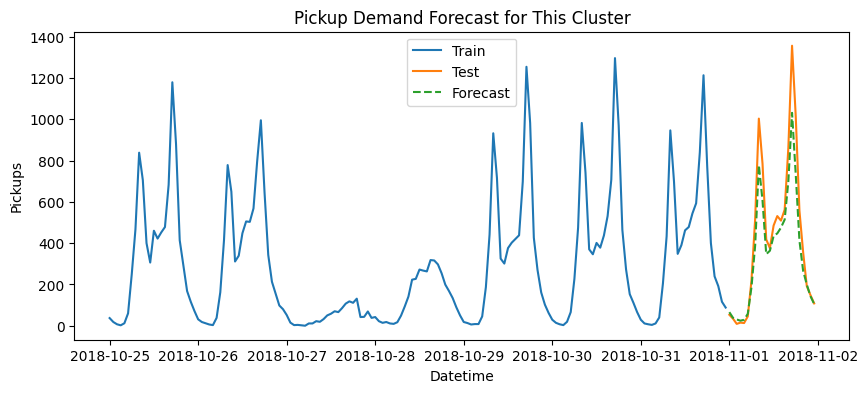

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit ARIMA model for this cluster
model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
fitted = model.fit(disp=False)

# Forecast next 24 hours
forecast = fitted.forecast(steps=24)

# Create forecast datetime index
last_train_datetime = train_data.index[-1]
forecast_index = pd.date_range(start=last_train_datetime + pd.Timedelta(hours=1), periods=24, freq='H')

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(train_data[-24*7:], label='Train')
plt.plot(test_data[:24], label='Test')
plt.plot(forecast_index, forecast, '--', label='Forecast')
plt.title('Pickup Demand Forecast for This Cluster')
plt.xlabel('Datetime')
plt.ylabel('Pickups')
plt.legend()
plt.show()

DROPOFFS PREDICTION

In [25]:
data_filtered_dropoffs = data[data['end_cluster_20'].isin(target_clusters)].copy()

data_filtered_dropoffs['dropoff_hour'] = data_filtered['stop_time'].dt.hour.astype("Int32")
data_filtered_dropoffs['date'] = data_filtered['stop_time'].dt.date

data_filtered_dropoffs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2263285 entries, 0 to 17545756
Data columns (total 17 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   tripduration             int64         
 1   start_station_id         float64       
 2   start_station_latitude   float64       
 3   start_station_longitude  float64       
 4   end_station_id           float64       
 5   end_station_latitude     float64       
 6   end_station_longitude    float64       
 7   bikeid                   int64         
 8   usertype                 int64         
 9   birth_year               int64         
 10  gender                   int64         
 11  start_time               datetime64[ns]
 12  stop_time                datetime64[ns]
 13  start_cluster_20         int32         
 14  end_cluster_20           Int32         
 15  dropoff_hour             Int32         
 16  date                     object        
dtypes: Int32(2), datetime64[ns](2),

In [26]:
# Count dropoffs per hour, per day (for this cluster)
cluster_hourly_drops = (
    data_filtered_dropoffs
    .groupby(['date', 'dropoff_hour'])
    ['end_station_id']
    .size()
    .reset_index()
    .rename(columns={'end_station_id': 'dropoffs'})
)


In [27]:
cluster_hourly_drops['datetime'] = pd.to_datetime(
    cluster_hourly_drops['date'].astype(str) + ' ' +
    cluster_hourly_drops['dropoff_hour'].astype(str) + ':00:00'
)
cluster_hourly_drops = cluster_hourly_drops.sort_values('datetime')
cluster_hourly_drops.head()

,date,dropoff_hour,dropoffs,datetime
0,2018-01-01,0,2,2018-01-01 00:00:00
1,2018-01-01,1,10,2018-01-01 01:00:00
2,2018-01-01,2,2,2018-01-01 02:00:00
3,2018-01-01,3,1,2018-01-01 03:00:00
4,2018-01-01,4,2,2018-01-01 04:00:00


In [31]:
# Ensure datetime index and hourly frequency
chd_drop = (
    cluster_hourly_drops
    .set_index('datetime')
    .sort_index()
    .asfreq('H')              # guarantees continuous hourly timeline
    .fillna({'dropoffs': 0})  # fill missing hours if any
)

# Keep only 2018 samples
chd_2018_drop = chd_drop.loc['2018-01-01':'2018-12-31 23:00']

# Train: Jan–Oct 2018
train_data_drop = chd_2018_drop.loc['2018-01-01':'2018-10-31 23:00', 'dropoffs']
print(train_data_drop)

# Test: Nov–Dec 2018
test_data_drop  = chd_2018_drop.loc['2018-11-01 00:00':'2018-12-31 23:00', 'dropoffs']


datetime
2018-01-01 00:00:00      2.0
2018-01-01 01:00:00     10.0
2018-01-01 02:00:00      2.0
2018-01-01 03:00:00      1.0
2018-01-01 04:00:00      2.0
                       ...  
2018-10-31 19:00:00    116.0
2018-10-31 20:00:00     69.0
2018-10-31 21:00:00     57.0
2018-10-31 22:00:00     36.0
2018-10-31 23:00:00     36.0
Freq: h, Name: dropoffs, Length: 7296, dtype: float64


C:\Users\billy\AppData\Local\Temp\ipykernel_16364\490359717.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .asfreq('H')              # guarantees continuous hourly timeline


C:\Users\billy\AppData\Local\Temp\ipykernel_16364\1894603461.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_drop_index = pd.date_range(start=train_data_drop.index[-1] + pd.Timedelta(hours=1),periods=24, freq='H')


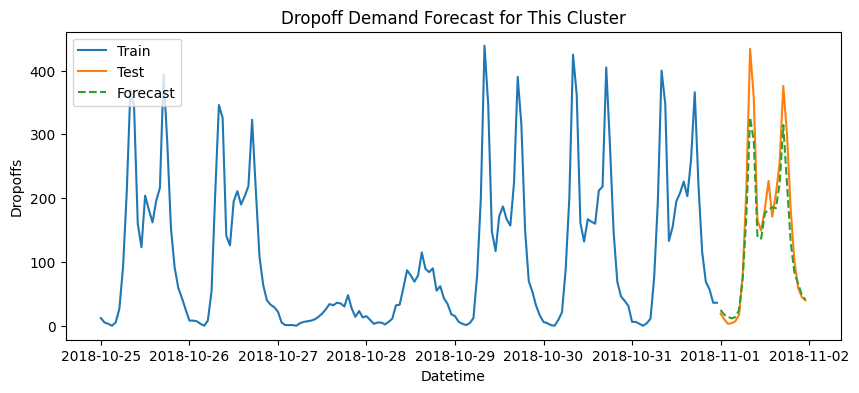

In [29]:
# Fit ARIMA model for this cluster
model = SARIMAX(train_data_drop, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
fitted = model.fit(disp=False)

# Forecast next 24 hours
forecast_drop = fitted.forecast(steps=24)

# Create forecast datetime index
last_train_datetime = train_data_drop.index[-1]
forecast_drop_index = pd.date_range(start=train_data_drop.index[-1] + pd.Timedelta(hours=1),periods=24, freq='H')

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(train_data_drop[-24*7:], label='Train')
plt.plot(test_data_drop[:24], label='Test')
plt.plot(forecast_drop_index, forecast_drop, '--', label='Forecast')
plt.title('Dropoff Demand Forecast for This Cluster')
plt.xlabel('Datetime')
plt.ylabel('Dropoffs')
plt.legend()
plt.show()

TASK 3

Create a combined dataframe that contains all pickups and dropoffs. We merge the train sets from task 2 and the predictions we made for pickups and dropoffs

In [32]:
train_data_df = pd.DataFrame(train_data)
train_data_drop_df = pd.DataFrame(train_data_drop)

# Merge train data columns for pickups and dropoffs (axis=1)
merged_train_data = pd.concat([train_data_df, train_data_drop_df], axis=1)


picks_forecast_df = pd.DataFrame(forecast)
picks_forecast_df.columns = ['pickups']
picks_forecast_df.index.name = 'datetime'
#picks_forecast_df.info()

drops_forecast_df = pd.DataFrame(forecast_drop)
drops_forecast_df.columns = ['dropoffs']
drops_forecast_df.index.name = 'datetime'
#drops_forecast_df.info()

# Combine forecasts into one DataFrame
forecast_next_day = pd.concat([picks_forecast_df, drops_forecast_df], axis=1)
forecast_next_day.columns = ['pickups', 'dropoffs']

forecast_next_day_df =  pd.concat([merged_train_data,forecast_next_day], axis=0)
forecast_next_day_df



,pickups,dropoffs
datetime,,
2018-01-01 00:00:00,12.000000,2.000000
2018-01-01 01:00:00,15.000000,10.000000
2018-01-01 02:00:00,7.000000,2.000000
2018-01-01 03:00:00,7.000000,1.000000
2018-01-01 04:00:00,2.000000,2.000000
...,...,...
2018-11-01 19:00:00,413.487552,131.306140
2018-11-01 20:00:00,266.519039,83.728857
2018-11-01 21:00:00,199.554640,66.197937


In [33]:
# Prompt the user to input the date
date_input = input("Enter the date for which you want to predict reposition needs (YYYY-MM-DD): ")

# Parse the input as a datetime
import datetime
try:
    target_date = datetime.datetime.strptime(date_input, "%Y-%m-%d").date()
    print(f"Processing reposition needs for: {target_date}")
except ValueError:
    print("Invalid date format. Please enter the date in YYYY-MM-DD format.")

Processing reposition needs for: 2018-11-01


In [34]:
# Calculate net flow: pickups = departures
net_flow = forecast_next_day_df['pickups'] - forecast_next_day_df['dropoffs']
forecast_next_day_df['net'] = net_flow
forecast_next_day_df



,pickups,dropoffs,net
datetime,,,
2018-01-01 00:00:00,12.000000,2.000000,10.000000
2018-01-01 01:00:00,15.000000,10.000000,5.000000
2018-01-01 02:00:00,7.000000,2.000000,5.000000
2018-01-01 03:00:00,7.000000,1.000000,6.000000
2018-01-01 04:00:00,2.000000,2.000000,0.000000
...,...,...,...
2018-11-01 19:00:00,413.487552,131.306140,282.181412
2018-11-01 20:00:00,266.519039,83.728857,182.790182
2018-11-01 21:00:00,199.554640,66.197937,133.356704


In [ ]:
import math

mask = forecast_next_day_df.index.date == target_date
day_netflow = forecast_next_day_df.loc[mask, 'net'].max()

# Required bikes at start of day
required_bikes = math.ceil(max(0, day_netflow))
print(f"Number of bikes to reposition on {target_date} is: {required_bikes}")

Number of bikes to reposition on 2018-11-01 is: 717


In [154]:
# Example: Filter for the target day
#mask = forecast_next_day_df.index.date == target_date
#day_pickups = forecast_next_day_df.loc[mask, 'pickups'].max()
#day_dropoffs = forecast_next_day_df.loc[mask, 'dropoffs'].max()

#print(f"Maximum expected pickups for {target_date}: {day_pickups}")
#print(f"Maximum expected dropoffs for {target_date}: {day_dropoffs}")
#required_bikes = math.ceil(day_pickups - day_dropoffs)
#print(f"Required bikes at start of day {date}: {(required_bikes)}")

# Step 3: Calculate inventory from yesterday
#yesterday = target_date - datetime.timedelta(days=1)
#yesterday_mask = forecast_next_day_df.index.date == yesterday
#yesterday_pickups = forecast_next_day_df.loc[yesterday_mask, 'pickups'].max()
#yesterday_dropoffs = forecast_next_day_df.loc[yesterday_mask, 'dropoffs'].max()

#inventory = yesterday_dropoffs - yesterday_pickups 
#print(f"Inventory from yesterday ({yesterday}): {inventory}")

#bikes_to_reposition = max(0,required_bikes-inventory)
#print(f"Numbers to reposition to cover demand on {date} is: {math.ceil(bikes_to_reposition)}")



